<p></p>

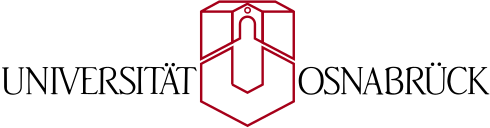
# <center>Einführung in die Künstliche Intelligenz</center> <a class="tocSkip">
### <center>Wintersemester 2020/21</center> <a class="tocSkip">
<center>Prof. Dr. Joachim Hertzberg, Felix Igelbrink, Alexander Mock</center>

# Übungsblatt 4: Spielbäume

## Programmieraufgabe: 2048 mit Minimax

In dieser Aufgabe werden wir die Spiellogik für das Spiel [2048](https://de.wikipedia.org/wiki/2048_(Computerspiel)) aus dem ersten Übungsblatt wieder aufgreifen.
Allerdings werden Sie nun mit Ihrem Wissen aus der Vorlesung eine einfache KI auf Basis des Minimax-Algorithmus implementieren.
Beantworten Sie zur Vorbereitung zunächst die folgenden Fragen:

### 
Der Minimax-Algorithmus ist eigentlich für 2 gegeneinander spielende Spieler ausgelegt. 2048 wird jedoch allein gespielt. Erläutern Sie, wie das Spiel trotzdem mit Minimax gespielt werden kann. Wer ist der minimierende, wer der maximierende Spieler?

Spieler ist maximierender Spieler, das Spiel selbst minimierender Spieler (stimmt zwar eigtl. nicht, aber Annahme für Minimax)

### 
Entwerfen Sie eine geeignete Bewertungsfunktion für einen Spielzustand und erläutern Sie Ihre Überlegungen. 

*Hinweis*: Um die Laufzeit des Algorithmus gering zu halten, sollten Sie dabei versuchen eine möglichst einfache Funktion zu finden.

Nutzen = Summe aller Felder auf dem Spielboard / |belegte Felder auf dem Spielboard|

### 
Erweitern Sie die unten gegebene Programmiervorlage um die nötigen Funktionen zur Bewertung des Spielzustandes. Erweitern Sie außerdem die `Board2048`- Klasse um die Ermittlung der möglichen Züge für beide "Spieler". 

*Hinweis*: Selbstverständlich können Sie auch Ihre eigene Implementation der Spiellogik von Blatt 0 als Ausgangsbasis verwenden.

In [1]:
import numpy as np
from enum import IntEnum
import copy


class Action(IntEnum):
    """
    Represents the possible actions as ints. 
    Note, that the order of the items should not be changed, 
    as they indictate the number of rotations necessary for the sliding step.
    """
    left = 0
    up = 1
    right = 2
    down = 3


class Board2048(object):
    def __init__(self, width: int =4, height: int =4, seed=None):
        """
        Represents a 2048 board with width and height. Actions can be performed on the board 
        with the step() function.
        
        Parameters
        ----------
        with: int
            The width of the board
        height: int
            The height of the board
        seed: any
            The seed for the random state. Using the same seed will result in the same game to be played
        """
        self.width: int = width
        self.height: int = height
        self.score: int = 0
            
        # Internal Variables
        self.board = None
        self.np_random = None

        self.seed(seed=seed)
        self.reset()
        

    def seed(self, seed=None):
        """
        Seed the random state.
        
        Parameters
        ----------
        seed: any
            The seed for the random state. Using the same seed will result in the same game to be played
        """
        
        self.np_random = np.random.RandomState(seed=seed)
        return [seed]

    def step(self, action: Action):
        """
        Perform one action on the board. 
        Possible actions are [left, right, up, down]. 
        Note, that impossible actions will result in no board change.
        
        Parameters
        ----------
        action: Action
            The action to perform

        Returns
        -------
        board: array_like
            The new board state
        score: int
            The gained score from this move
        game_over: bool
            Is the game over?
        dict: dict
            Currently unused (but expected by the test code later!)
        """

        game_over = False
        new_board, score = self.do_action(action)
       
       
        if np.any(new_board != self.board):
            # Place one random tile on empty location
            self._place_random_tiles(new_board, count=1)
        self.board = new_board
        game_over = self.game_over()

        self.score += score
        
        return self.board, score, game_over, {}
    
    def do_action(self, action):
        # Align board action with left action
        rotated_obs = np.rot90(self.board, k=action)
        score, updated_obs = self._slide_and_merge(rotated_obs)
        return np.rot90(updated_obs, k=4 - action), score

    def game_over(self, who: str = 'max'):
        """
        Check if the game is over.

        Returns
        -------
        game_over: bool
            True if the game is over, False otherwise
        """
        
        if who == 'max':
            copy_board = self.board.copy()

            if not copy_board.all():
                return False

            for action in Action:
                rotated_obs = np.rot90(copy_board, k=action)
                _, updated_obs = self._slide_and_merge(rotated_obs)
                if not updated_obs.all():
                    return False
            return True
        elif who == 'min':
            return self.board.all()

    def reset(self):
        """Place 2 tiles on the empty board."""

        self.board = np.zeros((self.width, self.height), dtype=np.int64)
        self._place_random_tiles(self.board, count=2)

        return self.board

    def _sample_tiles(self, count=1):
        """Sample tile 2 or 4."""

        choices = [2, 4]
        probs = [0.9, 0.1]

        tiles = self.np_random.choice(choices,
                                      size=count,
                                      p=probs)
        return tiles.tolist()

    def _sample_tile_locations(self, board, count=1):
        """Sample grid locations with no tile."""

        zero_locs = np.argwhere(board == 0)
        zero_indices = self.np_random.choice(
            len(zero_locs), size=count)

        zero_pos = zero_locs[zero_indices]
        zero_pos = list(zip(*zero_pos))
        return zero_pos

    def _place_random_tiles(self, board, count=1):
        """
        Place count random tiles on the board. 
        
        Parameters
        ----------
        board: array_like
            The board to place the tiles on
        count: int
            The number of tiles to place (default: 1)
        """
        if not board.all():
            tiles = self._sample_tiles(count)
            tile_locs = tuple(self._sample_tile_locations(board, count))
            board[tile_locs] = tiles

    def _slide_and_merge(self, board):
        """Slide tiles on the board to the left and merge.
        
        Parameters
        ----------
        board: array_like
            The board to slide
        """

        result = []

        score = 0
        for row in board:
            row = np.extract(row > 0, row)
            score_, result_row = self._try_merge(row)
            score += score_
            row = np.pad(np.array(result_row), (0, self.width - len(result_row)),
                         'constant', constant_values=(0,))
            result.append(row)
        return score, np.array(result, dtype=np.int64)

    @staticmethod
    def _try_merge(row):
        """Try to merge a row"""
        score = 0
        result_row = []

        i = 1
        while i < len(row):
            if row[i] == row[i - 1]:
                score += row[i] + row[i - 1]
                result_row.append(row[i] + row[i - 1])
                i += 2
            else:
                result_row.append(row[i - 1])
                i += 1

        if i == len(row):
            result_row.append(row[i - 1])

        return score, result_row
    
    
    def utility(state):
        """Berechne Nutzenwert des Spielboards: Summe aller Werte auf dem Feld / Anzahl freier Felder"""
       
        utility_val = 0
        penalty = 0
        sum_board = 0
        non_empty_fields = 0
        empty_fields = 0
        sum_board_one = 0
        sum_board_two = 0
        sum_board_three = 0
        sum_board_four = 0
        sum_board_five = 0
        sum_board_six = 0
        sum_board_seven = 0
        sum_board_eight = 0
        
        """for i in range(0, state.height):
            for j in range(1, state.width-1):
                if i == 0:
                    penalty += abs(state.board[i,j]-state.board[i+1,j])
                    penalty += abs(state.board[i,j]-state.board[i, j+1])
                    penalty += abs(state.board[i,j]-state.board[i, j-1])   
                elif i == state.height-1:
                    penalty += abs(state.board[i,j]-state.board[i-1, j])
                    penalty += abs(state.board[i,j]-state.board[i, j+1])
                    penalty += abs(state.board[i,j]-state.board[i, j-1])
                else:
                    penalty += abs(state.board[i,j]-state.board[i-1, j])
                    penalty += abs(state.board[i,j]-state.board[i+1,j])
                    penalty += abs(state.board[i,j]-state.board[i, j+1])
                    penalty += abs(state.board[i,j]-state.board[i, j-1])"""  

        snake_one = np.array([[2**15, 2**14, 2**13, 2**12], [2**8, 2**9, 2**10, 2**11], [2**7, 2**6, 2**5, 2**4], [2**0, 2**1, 2**2, 2**3]])
        snake_two = np.array([[2**12, 2**13, 2**14, 2**15], [2**11, 2**10, 2**9, 2**8], [2**4, 2**5, 2**6, 2**7], [2**3, 2**2, 2**1, 2**0]])
        snake_three = np.array([[2**3, 2**2, 2**1, 2**0], [2**4, 2**5, 2**6, 2**7], [2**11, 2**10, 2**9, 2**8], [2**12, 2**13, 2**14, 2**15]])
        snake_four = np.array([[2**0, 2**1, 2**2, 2**3], [2**7, 2**6, 2**5, 2**4], [2**8, 2**9, 2**10, 2**11], [2**15, 2**14, 2**13, 2**12]])
        snake_five = np.array([[2**15, 2**8, 2**7, 2**0], [2**14, 2**9, 2**6, 2**1], [2**13, 2**10, 2**5, 2**2], [2**12, 2**11, 2**4, 2**3]])
        snake_six = np.array([[2**12, 2**11, 2**4, 2**3], [2**13, 2**10, 2**5, 2**2], [2**14, 2**9, 2**6, 2**1], [2**15, 2**8, 2**7, 2**0]])
        snake_seven = np.array([[2**3, 2**4, 2**11, 2**12], [2**2, 2**5, 2**10, 2**13], [2**1, 2**6, 2**9, 2**14], [2**0, 2**7, 2**8, 2**15]])
        snake_eight = np.array([[2**0, 2**7, 2**8, 2**15], [2**1, 2**6, 2**9, 2**14], [2**2, 2**5, 2**10, 2**13], [2**3, 2**4, 2**11, 2**12]])

        for i in range(state.height):
            for j in range(state.width):
                if state.board[i,j] == 0:
                    empty_fields += 1
                sum_board_one += state.board[i,j] * snake_one[i,j]
                sum_board_two += state.board[i,j] * snake_two[i,j]
                sum_board_three += state.board[i,j] * snake_three[i,j]
                sum_board_four += state.board[i,j] * snake_four[i,j]
                sum_board_five += state.board[i,j] * snake_five[i,j]
                sum_board_six += state.board[i,j] * snake_six[i,j]
                sum_board_seven += state.board[i,j] * snake_seven[i,j]
                sum_board_eight += state.board[i,j] * snake_eight[i,j]
                
       
        max_sum = max(sum_board_one, sum_board_two, sum_board_three, sum_board_four, sum_board_five, sum_board_six, sum_board_seven, sum_board_eight)
        max_sum = max_sum/2**13

        #utility_val = 100*empty_fields-penalty+sum_board
        
        """for i in range(state.height):
            for j in range(state.width):
                if state.board[i,j] != 0:
                    non_empty_fields += 1
                sum_board += state.board[i,j]"""
                
        #utility_val = sum_board/non_empty_fields
        
        utility_val = max_sum+150*empty_fields
        
        return utility_val
    
    def minimize(state, alpha, beta, max_depth):
        """Berechne besten Nutzenwert für Min-Spieler"""
        if state.game_over('min') or max_depth == 0: 
            return (state, state.utility(), None)
        
        successor_states = state.successors('min')
        min_state = None
        min_score = beta
        move = None
        
        for succ_state, action in successor_states:
            state2, score, _ = succ_state.maximize(alpha, min_score, max_depth-1)
            if score < min_score:
                (min_state, min_score, move) = (succ_state, score, action)
            beta = min(beta, min_score)
            if alpha >= min_score:
                break         
        return (min_state, min_score, move)
                
        
        
    def maximize(state, alpha, beta, max_depth):
        """Berechne besten Nutzenwert für Max-Spieler"""
        if state.game_over('max') or max_depth == 0:
            return (state, state.utility(), None)
        
        successor_states = state.successors('max')
        max_state = None
        max_score = alpha
        move = None
        for succ_state, action in successor_states:
            score2, score, _ = succ_state.minimize(max_score, beta, max_depth-1)
            if score > max_score:
                (max_state, max_score, move) = (succ_state, score, action)
            alpha = max(max_score,alpha)
            if max_score >= beta:
                break        
        return (max_state, max_score, move)
                
        
    
    def successors(state, who: str):
        """Finde alle Nachfolger, d.h. alle möglichen Züge, von einem Spielstand"""
        new_state = None
        succ = []
        if who == 'min':
            for i in range(0, state.width):
                for j in range(0, state.height):
                    if state.board[i,j] == 0:
                        state_copy = copy.deepcopy(state)
                        state_copy.board[i,j] = 2
                        succ.append([state_copy, -1])
                        state_copy.board[i,j] = 4                        
                        succ.append([state_copy, -1])
        elif who == 'max':
            for i in range(0,4):
                state_copy = copy.deepcopy(state)
                state_copy.step(i)
                if not np.array_equal(state_copy.board, state.board):
                    succ.append((state_copy, i))
        
        return succ

### 
Implementieren Sie nun den Minimax-Algorithmus, um auf einem gegebenen `Board2048` den optimalen nächsten Zug zu berechnen. Implementieren Sie dabei auch *alpha*-*beta*-Pruning und achten Sie darauf die maximale Suchtiefe geeignet zu beschränken.

In [2]:
import random

def get_best_move(state: Board2048, max_depth: int = 10):
    #next_move = random.choice([Action.left, Action.up, Action.right, Action.down])
    state, score, action = state.maximize(float('-inf'), float('inf'), max_depth)
    time.sleep(0.2)
    
    print(state.utility())
    
    if action == 0:
        return Action.left
    elif action == 1:
        return Action.up
    elif action == 2:
        return Action.right
    elif action == 3:
        return Action.down

    return action

### Testcode
Mit dem folgenden Code können Sie Ihre Implementation testen.

In [4]:
from ipywidgets import interact, Button, IntText, GridBox, Layout, VBox, HBox, HTML, Output, Label
from IPython.display import display
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row, column, layout
from bokeh.models import CategoricalColorMapper, ColumnDataSource, Text
from bokeh.plotting import figure, output_file
import itertools
import time
output_notebook()

board_size = 4

# create the game board
board = Board2048(board_size, board_size)

line_width = 10
line_color = '#B8AD9A'  # the same for plot outline and rectangles border

title_fmt = "Move #{}: {:10s} Score: {:10d}"
p = figure(tools='', title=title_fmt.format(0, '', board.score), plot_width=400, plot_height=400, 
           x_range=(-0.5, board_size - 0.5), y_range=(board_size - 0.5, -0.5))

# make the graph look more like a game board
line_width = 10
line_color = '#B8AD9A'
p.outline_line_width = line_width
p.outline_line_color = line_color
p.xgrid.grid_line_color = p.ygrid.grid_line_color = None
p.title.align = 'right'
p.title.text_font_size = '1.5em'
p.axis.visible = False


color_dict = {0: '#D7D7D7', 2: '#ECE3AF', 4: '#E0D1A1', 8: '#D3B486', 16: '#F0AB79', 32: '#F18231',
              64: '#F73B0C', 128: '#DAD083', 256: '#D6C01E', 512: '#D4E80F', 1024: '#A3D829',
              2048: '#30D55A', 4096: '#B356E5', 8192: '#37E5E7', 16384: '#5117EA', 32768: '#C13695',
              65536: '#468A9C', 131072: '#9C4657'}
coord_pairs = [i for i in itertools.product(range(board.width), range(board.height))]
x, y = zip(*coord_pairs)

def update_source():
    global board
    data = board.board
    vals = [data[c] for c in coord_pairs]
    tile_colors = [color_dict[v] for v in vals]
    text_colors = ['black' if v != 0 else '#D7D7D7' for v in vals]  # make zero values invisible
    return dict(x=y, y=x, vals=vals, tile_colors=tile_colors, text_colors=text_colors)

# initial state of the data source
source = ColumnDataSource(update_source())

# draw tiles
p.rect(x='x', y='y', source=source, width=1, height=1, line_width=line_width,
       line_color=line_color, fill_color='tile_colors')

# add text
p.text(x='x', y='y', source=source, text='vals', text_align='center', 
       text_color='text_colors', text_font_size="1.5em")
            
show(p, notebook_handle=True)

moves_count = 1
max_depth = 3
while True:
    if board.game_over():
        print("Unfortunately, I lost the game.")
        print("Re-run this cell to start again.")
        break
    print('Search for best move...')
    move = get_best_move(board, max_depth)
    print(f'\rMove #{moves_count}: {move.name}')
    board.step(move)
    source.data = update_source()
    p.title.text = title_fmt.format(moves_count, move.name, board.score) #f"Score: {board.score}"
    push_notebook()
    moves_count += 1


Loading BokehJS ...

Search for best move...
1962.125
Move #1: down
Search for best move...
1966.03125
Move #2: up
Search for best move...
1974.125
Move #3: up
Search for best move...
1988.0
Move #4: right
Search for best move...
1990.0009765625
Move #5: up
Search for best move...
1842.25
Move #6: left
Search for best move...
1844.03125
Move #7: left
Search for best move...
1852.125
Move #8: left
Search for best move...
1848.3125
Move #9: down
Search for best move...
1848.126953125
Move #10: down
Search for best move...
1865.000244140625
Move #11: left
Search for best move...
1717.000244140625
Move #12: down
Search for best move...
1706.000732421875
Move #13: up
Search for best move...
1719.00048828125
Move #14: down
Search for best move...
1569.12890625
Move #15: left
Search for best move...
1570.1328125
Move #16: left
Search for best move...
1572.40625
Move #17: up
Search for best move...
1423.34375
Move #18: down
Search for best move...
1423.37548828125
Move #19: left
Search for best move...
1423.375244

2312.8203125
Move #154: up
Search for best move...
2470.3203125
Move #155: right
Search for best move...
2502.828125
Move #156: right
Search for best move...
2655.5
Move #157: up
Search for best move...
2657.0
Move #158: right
Search for best move...
2657.25
Move #159: right
Search for best move...
2507.7578125
Move #160: up
Search for best move...
2511.12890625
Move #161: left
Search for best move...
2358.0947265625
Move #162: right
Search for best move...
2211.271484375
Move #163: left
Search for best move...
2211.38330078125
Move #164: up
Search for best move...
2211.541015625
Move #165: left
Search for best move...
2215.197265625
Move #166: up
Search for best move...
2215.5107421875
Move #167: left
Search for best move...
2212.68798828125
Move #168: right
Search for best move...
2063.76220703125
Move #169: left
Search for best move...
1913.8251953125
Move #170: left
Search for best move...
2066.3515625
Move #171: up
Search for best move...
2066.38671875
Move #172: up
Search for bes

3261.063720703125
Move #305: up
Search for best move...
3262.34765625
Move #306: left
Search for best move...
3112.38671875
Move #307: left
Search for best move...
3112.75390625
Move #308: up
Search for best move...
3111.88330078125
Move #309: right
Search for best move...
3113.13330078125
Move #310: left
Search for best move...
3111.141845703125
Move #311: right
Search for best move...
3111.282470703125
Move #312: up
Search for best move...
3113.16796875
Move #313: left
Search for best move...
3266.1884765625
Move #314: up
Search for best move...
3116.251953125
Move #315: left
Search for best move...
3116.314697265625
Move #316: left
Search for best move...
3116.3173828125
Move #317: left
Search for best move...
3126.265869140625
Move #318: up
Search for best move...
2971.189697265625
Move #319: right
Search for best move...
3149.718994140625
Move #320: up
Search for best move...
3371.502197265625
Move #321: right
Search for best move...
3223.000244140625
Move #322: up
Search for best

3160.66259765625
Move #455: left
Search for best move...
3310.6806640625
Move #456: up
Search for best move...
3310.71142578125
Move #457: up
Search for best move...
3311.16455078125
Move #458: up
Search for best move...
3311.15087890625
Move #459: left
Search for best move...
3311.1533203125
Move #460: left
Search for best move...
3463.148681640625
Move #461: up
Search for best move...
3463.250732421875
Move #462: right
Search for best move...
3463.25439453125
Move #463: right
Search for best move...
3313.2666015625
Move #464: right
Search for best move...
3313.28369140625
Move #465: up
Search for best move...
3163.29345703125
Move #466: up
Search for best move...
3163.21533203125
Move #467: left
Search for best move...
3163.17724609375
Move #468: left
Search for best move...
3313.177734375
Move #469: left
Search for best move...
3317.1650390625
Move #470: up
Search for best move...
3326.15771484375
Move #471: up
Search for best move...
3326.1455078125
Move #472: left
Search for best 

4843.636962890625
Move #602: down
Search for best move...
4699.13525390625
Move #603: up
Search for best move...
4849.16552734375
Move #604: right
Search for best move...
4849.27392578125
Move #605: down
Search for best move...
5000.330078125
Move #606: right
Search for best move...
4850.197509765625
Move #607: up
Search for best move...
4850.2001953125
Move #608: up
Search for best move...
5004.1904296875
Move #609: right
Search for best move...
5004.31689453125
Move #610: down
Search for best move...
4854.32177734375
Move #611: down
Search for best move...
4854.33056640625
Move #612: right
Search for best move...
4704.3310546875
Move #613: down
Search for best move...
4704.33349609375
Move #614: down
Search for best move...
4704.333984375
Move #615: down
Search for best move...
4704.458984375
Move #616: right
Search for best move...
4704.336181640625
Move #617: up
Search for best move...
5156.16455078125
Move #618: right
Search for best move...
5151.289306640625
Move #619: down
Searc

6401.5
Move #750: right
Search for best move...
6553.125
Move #751: up
Search for best move...
6403.2578125
Move #752: up
Search for best move...
6251.66015625
Move #753: down
Search for best move...
6253.2734375
Move #754: up
Search for best move...
6254.26611328125
Move #755: right
Search for best move...
6254.34375
Move #756: right
Search for best move...
6254.56298828125
Move #757: right
Search for best move...
6104.563720703125
Move #758: down
Search for best move...
6104.57080078125
Move #759: down
Search for best move...
5954.62646484375
Move #760: down
Search for best move...
5954.69921875
Move #761: right
Search for best move...
5954.6328125
Move #762: up
Search for best move...
5804.673828125
Move #763: down
Search for best move...
5955.144775390625
Move #764: right
Search for best move...
5956.396484375
Move #765: up
Search for best move...
5956.400390625
Move #766: right
Search for best move...
6106.517822265625
Move #767: up
Search for best move...
6106.52734375
Move #768:

6491.12939453125
Move #899: down
Search for best move...
6492.140625
Move #900: right
Search for best move...
6343.537109375
Move #901: up
Search for best move...
6495.0078125
Move #902: right
Search for best move...
6342.53271484375
Move #903: down
Search for best move...
6195.00830078125
Move #904: up
Search for best move...
6195.039306640625
Move #905: right
Search for best move...
6196.09423828125
Move #906: right
Search for best move...
6196.11328125
Move #907: right
Search for best move...
6196.20361328125
Move #908: down
Search for best move...
6046.211181640625
Move #909: down
Search for best move...
6046.219970703125
Move #910: down
Search for best move...
6046.12109375
Move #911: up
Search for best move...
6046.126953125
Move #912: right
Search for best move...
6048.14453125
Move #913: right
Search for best move...
6202.19189453125
Move #914: up
Search for best move...
6206.349609375
Move #915: up
Search for best move...
6044.162353515625
Move #916: down
Search for best move.

5976.083984375
Move #1044: right
Search for best move...
4720.23681640625
Move #1045: up
Search for best move...
6768.236328125
Move #1046: up
Search for best move...
9019.009765625
Move #1047: down
Search for best move...
9202.421875
Move #1048: right
Search for best move...
9354.047119140625
Move #1049: up
Search for best move...
9508.0703125
Move #1050: right
Search for best move...
9358.093994140625
Move #1051: down
Search for best move...
9510.156494140625
Move #1052: right
Search for best move...
9364.318359375
Move #1053: up
Search for best move...
9519.34375
Move #1054: right
Search for best move...
9519.376953125
Move #1055: right
Search for best move...
9519.50244140625
Move #1056: up
Search for best move...
9366.7666015625
Move #1057: down
Search for best move...
9366.84765625
Move #1058: right
Search for best move...
9366.89111328125
Move #1059: down
Search for best move...
9517.53125
Move #1060: right
Search for best move...
9367.562744140625
Move #1061: down
Search for be

9627.289306640625
Move #1189: right
Search for best move...
9627.320556640625
Move #1190: right
Search for best move...
9477.287109375
Move #1191: up
Search for best move...
9477.3203125
Move #1192: right
Search for best move...
9627.3125
Move #1193: up
Search for best move...
9477.297119140625
Move #1194: up
Search for best move...
9327.344482421875
Move #1195: down
Search for best move...
9327.37939453125
Move #1196: right
Search for best move...
9327.3505859375
Move #1197: up
Search for best move...
9327.35302734375
Move #1198: right
Search for best move...
9477.33984375
Move #1199: up
Search for best move...
9327.4228515625
Move #1200: down
Search for best move...
9328.31396484375
Move #1201: right
Search for best move...
9328.27783203125
Move #1202: up
Search for best move...
9478.38427734375
Move #1203: down
Search for best move...
9328.39306640625
Move #1204: down
Search for best move...
9478.664306640625
Move #1205: right
Search for best move...
9328.5849609375
Move #1206: up
S

10242.359375
Move #1333: up
Search for best move...
10092.3779296875
Move #1334: down
Search for best move...
9942.38427734375
Move #1335: down
Search for best move...
10092.773681640625
Move #1336: right
Search for best move...
10092.782470703125
Move #1337: down
Search for best move...
10092.78369140625
Move #1338: down
Search for best move...
9942.79345703125
Move #1339: right
Search for best move...
9942.715087890625
Move #1340: up
Search for best move...
10093.18798828125
Move #1341: right
Search for best move...
10084.219970703125
Move #1342: down
Search for best move...
10094.33203125
Move #1343: up
Search for best move...
10094.31689453125
Move #1344: up
Search for best move...
10244.304931640625
Move #1345: up
Search for best move...
10244.40625
Move #1346: right
Search for best move...
10244.43798828125
Move #1347: right
Search for best move...
10244.5654296875
Move #1348: up
Search for best move...
10234.50830078125
Move #1349: down
Search for best move...
10234.695556640625

11422.8916015625
Move #1476: down
Search for best move...
11275.0390625
Move #1477: up
Search for best move...
11275.166015625
Move #1478: right
Search for best move...
11276.173828125
Move #1479: right
Search for best move...
11428.291015625
Move #1480: right
Search for best move...
11280.60546875
Move #1481: up
Search for best move...
11436.66015625
Move #1482: right
Search for best move...
11437.037109375
Move #1483: up
Search for best move...
11438.037353515625
Move #1484: up
Search for best move...
11439.070556640625
Move #1485: right
Search for best move...
11439.2578125
Move #1486: right
Search for best move...
11289.3134765625
Move #1487: down
Search for best move...
11139.314697265625
Move #1488: down
Search for best move...
11139.32861328125
Move #1489: down
Search for best move...
11289.56640625
Move #1490: right
Search for best move...
11139.521484375
Move #1491: up
Search for best move...
11139.525390625
Move #1492: right
Search for best move...
11139.625732421875
Move #14

10829.13330078125
Move #1619: right
Search for best move...
10988.127685546875
Move #1620: right
Search for best move...
10988.25537109375
Move #1621: down
Search for best move...
10988.2666015625
Move #1622: down
Search for best move...
11139.38330078125
Move #1623: right
Search for best move...
11139.146484375
Move #1624: up
Search for best move...
11293.023681640625
Move #1625: right
Search for best move...
11143.05517578125
Move #1626: right
Search for best move...
11288.094482421875
Move #1627: down
Search for best move...
11448.0205078125
Move #1628: up
Search for best move...
11450.015869140625
Move #1629: right
Search for best move...
11300.033203125
Move #1630: up
Search for best move...
11289.094482421875
Move #1631: down
Search for best move...
11439.12744140625
Move #1632: down
Search for best move...
11300.03515625
Move #1633: up
Search for best move...
11150.08984375
Move #1634: up
Search for best move...
11000.1611328125
Move #1635: down
Search for best move...
11000.270

11280.62744140625
Move #1761: down
Search for best move...
11280.55859375
Move #1762: up
Search for best move...
11280.551025390625
Move #1763: up
Search for best move...
11434.568359375
Move #1764: right
Search for best move...
11284.602783203125
Move #1765: down
Search for best move...
11284.5859375
Move #1766: up
Search for best move...
11284.63720703125
Move #1767: down
Search for best move...
11284.7001953125
Move #1768: right
Search for best move...
11434.782470703125
Move #1769: down
Search for best move...
11435.072265625
Move #1770: right
Search for best move...
11436.068359375
Move #1771: up
Search for best move...
11590.177734375
Move #1772: up
Search for best move...
11590.2421875
Move #1773: right
Search for best move...
11740.283203125
Move #1774: up
Search for best move...
11578.258056640625
Move #1775: down
Search for best move...
11440.318603515625
Move #1776: up
Search for best move...
11428.25927734375
Move #1777: down
Search for best move...
11290.3828125
Move #1778

11315.205322265625
Move #1903: down
Search for best move...
11315.2041015625
Move #1904: down
Search for best move...
11315.26806640625
Move #1905: right
Search for best move...
11315.136962890625
Move #1906: up
Search for best move...
11315.172119140625
Move #1907: right
Search for best move...
11315.20361328125
Move #1908: right
Search for best move...
11165.2060546875
Move #1909: up
Search for best move...
11165.2041015625
Move #1910: down
Search for best move...
11165.266357421875
Move #1911: right
Search for best move...
11315.41064453125
Move #1912: down
Search for best move...
11315.5712890625
Move #1913: down
Search for best move...
11316.13525390625
Move #1914: right
Search for best move...
11316.13720703125
Move #1915: down
Search for best move...
11316.199462890625
Move #1916: right
Search for best move...
11466.289306640625
Move #1917: down
Search for best move...
11316.177734375
Move #1918: up
Search for best move...
11316.1806640625
Move #1919: right
Search for best move.

## Zusatzaufgabe: Vier-Gewinnt

Als Zusatzaufgabe können Sie nun Ihre Minimax-Implementation auch auf das Zwei-Spieler-Spiel Vier-Gewinnt anpassen. Im Spiel gegen die KI können Sie so die Spielstärke Ihrer Implementation testen. 
Die folgende Klasse ``ConnectFour`` implementiert alle nötigen interaktionen mit dem Spielfeld.

In [ ]:
import numpy as np

def getPlayerName(state):
    if state < 0:
        return 'yellow'
    elif state > 0:
        return 'red'
    else:
        return 'nobody'

class ConnectFour(object):

    def __init__(self):
        """
        Constructor
        """
        self.state = 1
        self.board = np.zeros((6,7), dtype=np.int8)
        # careful: internally it is stored 6x7
        self.width = 7
        self.height = 6

    def move(self, col):
        """
        Try to insert a stone in the given column. On success the board state is updated.
        :param col: the column to insert the stone
        :return: True if the move was successful, False otherwise
        """
        if self.is_over():
            return False

        rows = self.board.shape[0]

        for row in reversed(range(rows)):
            if self.board[row, col] == 0:
                self.board[row, col] = self.state
                self.__update_state(row, col)
                return True

        return False

    def __update_state(self, row, col):
        """
        Update the game state. Internal method, not for external use.
        :param row: the row to update
        :param col: the column to update
        """
        rows = self.board.shape[0]
        cols = self.board.shape[1]

        def f(drow, dcol):
            return     0 <= row + drow < rows \
                   and 0 <= col + dcol < cols \
                   and bool(self.board[row, col] == self.board[row + drow, col + dcol])

        def g(drow, dcol):
            len = 0
            for i in range(1, 4):
                if f(i * drow, i * dcol):
                    len += 1
                else:
                    break
            return len

        def h(drow, dcol):
            return g(-drow, -dcol) + g(drow, dcol) >= 3

        if np.all(self.board[0, :] != 0):
            self.state = 0
        if h(1, 0) or h(0, 1) or h(1, 1) or h(-1, 1):
            self.state *= 2
        else:
            self.state *= -1

    def is_over(self):
        """
        Check if the game is over
        :return: True if over, False otherwise
        """
        return abs(self.state) != 1

### 
Die Methode ``choose_move`` wählt den nächsten Spielzug rein zufällig. Erweitern Sie diese Methode um eine geeignetere Strategie. Diesen KI-Spieler können Sie dann direkt mit der Zelle darunter Testen, indem Sie selbst gegen ihn antreten.

In [ ]:
import numpy as np

def choose_move(board):
    next_move = np.random.randint(0,6)
    #TODO: INSERT YOUR CODE HERE
    
    return next_move

In [ ]:
from ipywidgets import interact, Button, IntText, GridBox, Layout, VBox, HBox, HTML, Output, Label
from IPython.display import display
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row, column, layout
from bokeh.models import CategoricalColorMapper, ColumnDataSource, Text
from bokeh.plotting import figure, output_file
import itertools
output_notebook()


# create the game board
board = ConnectFour()

line_width = 10
line_color = '#B8AD9A'  # the same for plot outline and rectangles border

#p = figure(tools='', title=f"Score: {board.score}", plot_width=400, plot_height=400, 
#           x_range=(-0.5, board_size - 0.5), y_range=(board_size - 0.5, -0.5))
p = figure(tools='', plot_width=400, plot_height=400, 
           x_range=(-0.5, board.width - 0.5), y_range=(board.height - 0.5, -0.5))

# make the graph look more like a game board
line_width = 10
line_color = '#B8AD9A'
p.outline_line_width = line_width
p.outline_line_color = line_color
p.xgrid.grid_line_color = p.ygrid.grid_line_color = None
p.title.align = 'right'
p.title.text_font_size = '1.5em'
p.axis.visible = False


color_dict = {0: '#D7D7D7', 1: '#FF0000', -1: '#FFFF00'}
coord_pairs = [i for i in itertools.product(range(board.width), range(board.height))]
x, y = zip(*coord_pairs)

def update_source():
    global board
    data = np.flip(np.rot90(board.board), axis=0)
    vals = [data[c] for c in coord_pairs]
    tile_colors = [color_dict[v] for v in vals]
    text_colors = ['back' if v != 0 else '#D7D7D7' for v in vals]  # make zero values invisible
    return dict(x=x, y=y, vals=vals, tile_colors=tile_colors, text_colors=text_colors)


# arrange controls in a grid box
current_player = 'red'
player_fmt = "<b><font size=4>Player: <font color='{0}'><font size=4>{0}</b>"
playerlabel = HTML(value = player_fmt.format(current_player))
display(playerlabel)


# this updates the board object based on the direction of the calling button, then recreates the datasource
def on_button_clicked(b):
    global board, source, current_player
    
    
    # 1. Human
    board.move(int(b.description))
    source.data = update_source()
    
    # check game over
    if board.is_over():
        print('GAME OVER: %s wins!' % getPlayerName(board.state))
        push_notebook()
        return
    
    # update player
    current_player = getPlayerName(board.state*-1)
    playerlabel.value = player_fmt.format(current_player)
    push_notebook()
    
    # 2. Computer
    board.move(choose_move(board))
    source.data = update_source()
    
    # check game over
    if board.is_over():
        print('GAME OVER: %s wins!' % getPlayerName(board.state))
        push_notebook()
        return
    
    # update player
    current_player = getPlayerName(board.state * -1)
    playerlabel.value = player_fmt.format(current_player)
    push_notebook()

# create action buttons
btns = []
for i in range(board.width):
    btns.append(Button(description='%d' % i, layout=Layout(width='auto')))

    # link buttons to function
for button in btns:
    button.on_click(on_button_clicked)

gbox = GridBox(children=btns, layout=Layout(
            width='100%',
            grid_gap= '4px',
            grid_template_rows='repeat(1, 40px)',
            grid_template_columns='repeat(%d, 50px)' % board.width
        ))
display(gbox)
# initial state of the data source
source = ColumnDataSource(update_source())

# draw tiles
p.rect(x='x', y='y', source=source, width=1, height=1, line_width=line_width,
       line_color=line_color, fill_color='tile_colors')

# add text
p.text(x='x', y='y', source=source, text='vals', text_align='center', 
       text_color='text_colors', text_font_size="1.5em")

show(p, notebook_handle=True)

## Aufgabe: Aussagenlogik

Betrachten Sie die beiden folgenden Ausdrücke:
\begin{eqnarray}
  \neg ( A \vee B ) \equiv \neg A \wedge \neg B \label{eq:equiv}\\
  \neg ( A \vee B ) \Leftrightarrow \neg A \wedge \neg B \label{eq:co_imp}
\end{eqnarray}

Zeigen oder widerlegen Sie, dass die Ausdrücke im Sinne der Aussagelogik gleich sind.

YOUR ANSWER HERE

## Aufgabe: Boolesche Logik

Gegeben seien die beiden zweistelligen aussagelogischen Junktoren NOR
($\dagger$) und NAND ($\ddagger$) durch die folgede Wahrheitstabelle.

|$A$  |$B$  |$A\dagger B$  |$A\ddagger B$  |
|:---:|:---:|:------------:|:-------------:|
| 0 | 0 |     1      |      1      |
| 0 | 1 |     0      |      1      |
| 1 | 0 |     0      |      1      |
| 1 | 1 |     0      |      0      |

### 
Zeigen oder widerlegen Sie, dass NAND funktional vollständig ist, d.h. dass die üblichen Junktoren der
Aussagelogik, welche Sie in der Vorlesung kennengelernt haben, allesamt durch NAND ausgedrückt
werden können.

### 
Wie lässt sich nun leicht für den zweistelligen Junktor NOR analog zeigen, dass er bzgl. funktionaler
Vollständigkeit die gleichen Eigenschaften besitzt wie NAND? Geben Sie einen Beweis an.

YOUR ANSWER HERE

## Davis / Putnam

Folgende Sätze seien gegeben:
\begin{eqnarray*}
             &   & S \\
  (P \vee  T) &\Rightarrow& Q \\
  (S \wedge Q) &\Rightarrow& R \\
             &   & T
\end{eqnarray*}

### 
Formen Sie die Formelmenge in eine Klauselmenge um.

### 
Beweisen Sie die Erfüllbarkeit mit dem Verfahren von Davis/Putnam

## Programmieraufgabe: Prolog

Zur Modellierung von Logischen Zusammenhängen hat sich die Programmiersprache *Prolog* durchgesetzt. Um diese Sprache zu nutzen, müssen Sie die Software `SWI-Prolog` installieren. Diese sollte unter Linux in den gängigen Paketquellen verfügbar sein. Für Windows können Sie die Software [hier](https://www.swi-prolog.org/download/stable) herunterladen. Mit dem Befehl `swipl` können Sie Ihre Prolog-Umgebung starten. 

### 
Bearbeiten Sie mindestens Kapitel 1 von http://www.learnprolognow.org.

### 
Welche der folgenden Ausdrücke sind Prolog Atome, welche sind Variablen und welche sind keines der beiden?
    
    OPIUM
    Klausuranmeldung
    25.01.2021
    variable42
    42variable
    'KI_ist_toll'
    Prolog_macht_spass

Variablen: 
- OPIUM
- Klausuranmeldung
- Prolog_macht_spass

Atome:
- variable42
- 'KI_ist_toll'

Nichts:
- 42variable
- 25.01.2021

### Prolog in Python

*Prolog* ist leider nicht direkt für die Verwendung in Jupyter-Notebooks gedacht. Für Python exisiert jedoch das Paket [`pyswip`](https://github.com/yuce/pyswip), welches einen *Prolog*-Interpreter als Objekt in Python zur Verfügung stellt. Sie können das Paket mit
```bash
pip install pyswip
```

in Ihrer `conda`-Umgebung installieren.

*Hinweis*: `pyswip` setzt voraus, dass SWI-Prolog bereits im System installiert ist und gefunden werden kann.

Gegeben sei folgende Wissensbasis:

In [ ]:
from pyswip import Prolog

pro = Prolog()
pro.assertz("opium_anmeldung(peter)")
pro.assertz("opium_anmeldung(paul)")
pro.assertz("opium_anmeldung(frank)")
pro.assertz("uebungen_bestanden(peter)")
pro.assertz("uebungen_bestanden(friedhelm)")
pro.assertz("uebungen_bestanden(oliver)")
pro.assertz("uebungen_bestanden(frank)")

    
Schreiben Sie das Prolog-Prädikat `klausur_zulassung(X)` um zu prüfen, ob jemand zur Klausur zugelassen ist. Zur Klausurzulassung wird in dieser fiktiven Veranstaltung sowohl eine Opiumanmeldung als
auch das Bestehen der Übungen benötigt. Wie kann man sich mit Hilfe dieses Prädikats von Prolog alle zugelassenen Personen (nacheinander) ausgeben lassen? Wie müssen Sie das Prädikat `klausur_zulassung(X)`
anpassen, damit es zur aktuellen KI-Veranstaltung passt?

In [ ]:
pro.assertz("klausur_zulassung(X):- opium_anmeldung(X), uebungen_bestanden(X)")

pro.query("klausur_zulassung(X)")
for X in pro.query("klausur_zulassung(X)"):
    print(X)

